In [1]:
import numpy as np
import os
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage import io
from PIL import Image
from math import sqrt
import importlib
import utils

base_skin_dir = os.path.join('', 'input')

In [2]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
2607,HAM_0005396,ISIC_0032834,bcc,histo,75.0,male,abdomen,input/HAM10000_images_part_2/ISIC_0032834.jpg,Basal cell carcinoma,1
4963,HAM_0004096,ISIC_0028541,nv,follow_up,50.0,female,lower extremity,input/HAM10000_images_part_1/ISIC_0028541.jpg,Melanocytic nevi,4
1300,HAM_0006521,ISIC_0025155,mel,histo,80.0,male,lower extremity,input/HAM10000_images_part_1/ISIC_0025155.jpg,dermatofibroma,6


In [3]:
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0001863,ISIC_0033093,nv,histo,male,back,input/HAM10000_images_part_2/ISIC_0031646.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


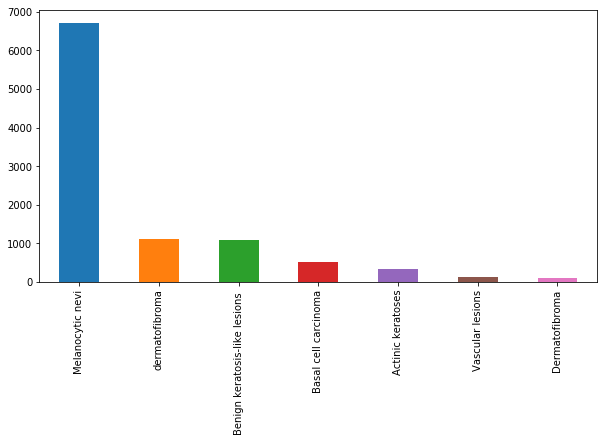

In [4]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [5]:
#Show data set shape
print('Data set shape: ', tile_df.shape)

tile_df.isnull().sum()

Data set shape:  (10015, 10)


lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [6]:
try:
   del X_train, y_train, X_path_training_dev, X_path_test_dev
   del X_test, y_test, data_set_dev
   print('Clear previously loaded data.')
except:
   pass

num_training = 5000

#data_set_dev = tile_df
data_set_dev = tile_df.iloc[0:num_training].copy()
print(data_set_dev.shape)

# load in all of the images
#from skimage.io import imread
data_set_dev['image'] = data_set_dev['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

print(data_set_dev['image'][0].shape)
#num_test = 5
data_set_dev.isnull().sum()

(5000, 10)
(75, 100, 3)


lesion_id         0
image_id          0
dx                0
dx_type           0
age              12
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
image             0
dtype: int64

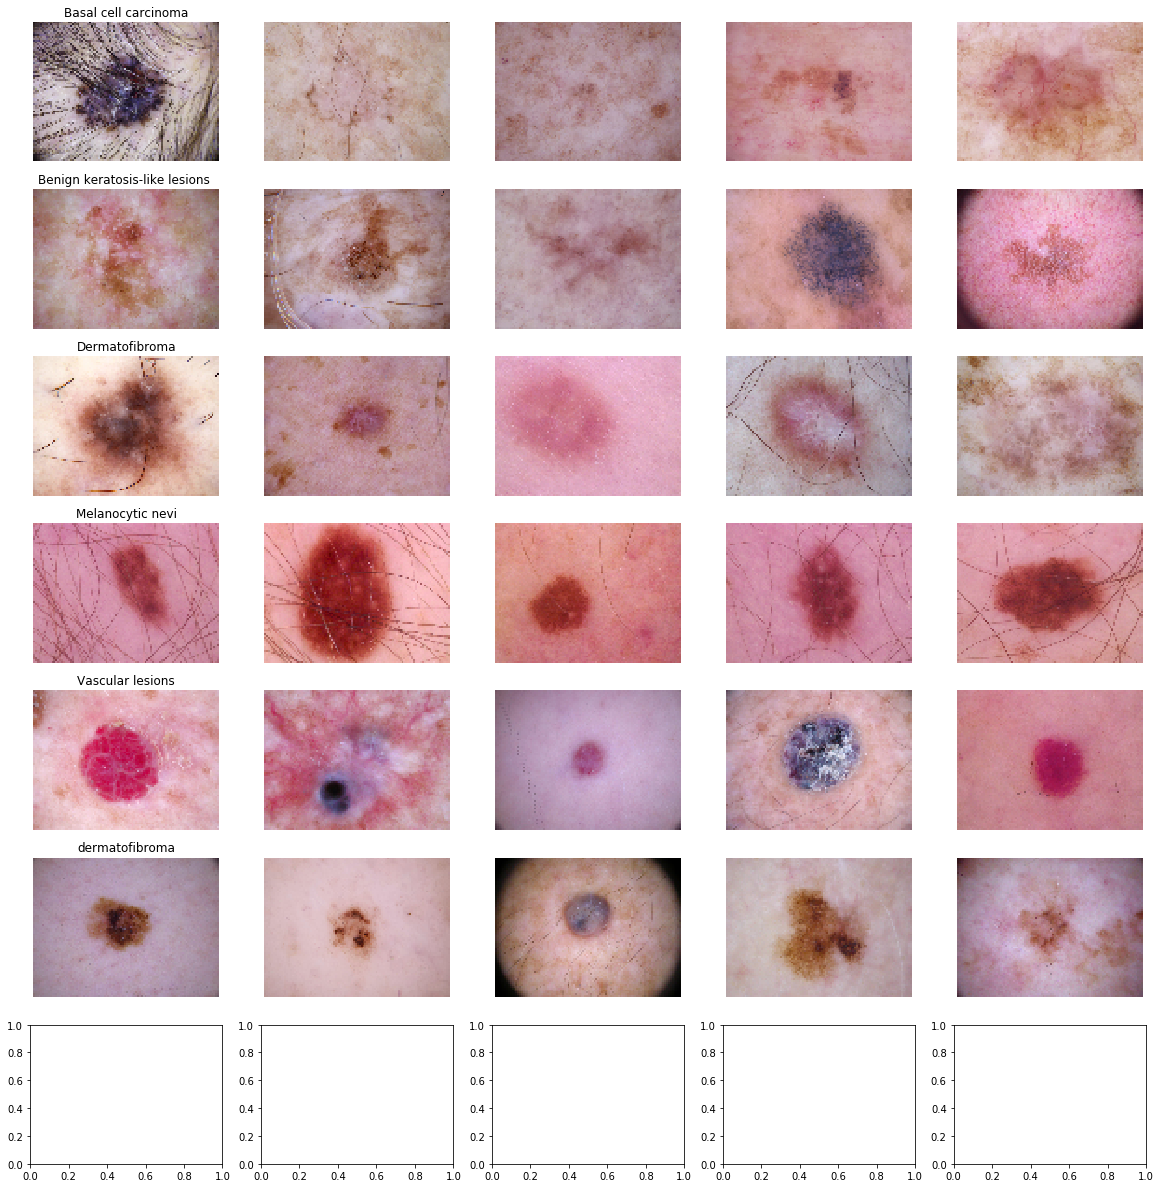

In [15]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         data_set_dev.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [7]:
features = data_set_dev.drop(columns=['cell_type_idx'],axis=1)
target = data_set_dev['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

#y_train = to_categorical(y_train_o, num_classes = 7)
#y_test = to_categorical(y_test_o, num_classes = 7)

print("Shape training ", x_train_o.shape)
print("Shape test ", x_test_o.shape)
print("Shape y ", y_train_o.shape)
print(y_train_o.value_counts())
print(y_train_o[1500])

print("Vacios y_train_o")
y_train_o.isnull().sum()
y_train_o.dtypes

Shape training  (4000, 10)
Shape test  (1000, 10)
Shape y  (4000,)
4    1633
6     878
2     878
1     412
5     108
3      91
Name: cell_type_idx, dtype: int64
6
Vacios y_train_o


dtype('int8')

In [8]:
#Data preprocessing
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

y_train = np.asarray(y_train_o.tolist())
y_test = np.asarray(y_test_o.tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

#imag = plt.imshow(x_train[3])

print(x_train.shape)

print(x_train.dtype)
print(x_train[0].shape)

(4000, 75, 100, 3)
float64
(75, 100, 3)


In [9]:
#Splitting training and validation data
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

print(x_train[0].shape)


(75, 100, 3)


In [14]:
import csv
importlib.reload(utils)

D = 22500 #Dimensionality
K = 7 #Number of classes


W = utils.weigh_initialization(D,K)

reg = 0.000001
delta = 1
loss = utils.SVM_loss(W, x_train, y_train, reg, delta)

#grad = utils.gradient(W, x_train, y_train, reg, delta)

print(loss)
print(W.shape)

5.861579099955056
(7, 22501)
